In [1]:
import jax
from jax import numpy as jnp
from matplotlib import pyplot as plt
import optax
from deep_nn_odes.image_dataset_loader import MNISTDatasetLoader, CIFAR10DatasetLoader
from deep_nn_odes.cnn_model import init_cnn_parameters, cnn_model

%matplotlib inline

In [2]:
def fit(model, params, optimizer, image_dataset_loader, batch_size=128, nepoch=10):
    """Fit the CNN classifier using cross-entropy loss

    :arg model: the model to fit
    :arg params: fit parameters
    :arg optimizer: optimizer
    :arg image_dataset_loader: loader for image dataset
    :arg batch_size: size of training batches
    :arg nepoch: number of epochs
    """
    from collections import defaultdict

    opt_state = optimizer.init(params)

    def accuracy(params, model_state, x, y):
        """Compute accuracy, i.e. fraction of correct predictions
        in a minibatch

        :arg params: model parameters
        :arg model: model
        :arg x: minibatch of input images
        :arg y: minibatch of labels
        """
        y_pred = model(params, model_state, x)
        n_total = y.shape[0]
        n_correct = jnp.sum(1 * (jnp.argmax(jax.nn.softmax(y_pred), axis=-1) == y))
        return n_correct / n_total

    def loss(params, model_state, x, y):
        """Cross-entropy loss function

        :arg params: model parameters
        :arg model: model
        :arg x: minibatch of input images
        :arg y: minibatch of labels
        """
        logits = model(params, model_state, x)
        return optax.softmax_cross_entropy_with_integer_labels(logits, y).mean()

    @jax.jit
    def step(params, model_state, opt_state, X_batch, y_batch):
        """Single update step"""
        loss_value, grads = jax.value_and_grad(loss)(
            params, model_state, X_batch, y_batch
        )
        acc_value = accuracy(params, model_state, X_batch, y_batch)
        updates, opt_state = optimizer.update(grads, opt_state)
        params = optax.apply_updates(params, updates)
        return params, model_state, opt_state, loss_value, acc_value

    X_valid, y_valid = image_dataset_loader.get_validation_data()
    metrics = defaultdict(list)
    rngkey = jax.random.PRNGKey(seed=37)
    # CNN model states for training and validation
    train_state = dict(rngkey=rngkey, p_dropout=0.2)
    valid_state = dict(rngkey=rngkey, p_dropout=0)
    # Loop over epochs
    for epoch in range(nepoch):
        acc_train = 0.0
        # iterate over all batches
        for n, (X_batch, y_batch) in enumerate(
            zip(*image_dataset_loader.get_shuffled_batched_train_data(batch_size))
        ):
            params, train_state, opt_state, loss_train, acc_batch = step(
                params, train_state, opt_state, X_batch, y_batch
            )
            # Update the rolling sum of the training accuracy
            acc_train += (acc_batch - acc_train) / (n + 1)
        # compute loss and accuracy on validation data
        loss_valid = loss(params, valid_state, X_valid, y_valid)
        acc_valid = accuracy(params, valid_state, X_valid, y_valid)
        print(f"**** epoch {(epoch+1):4d} of {nepoch:4d} ****")
        print(f"                loss = {loss_train:8.3e}  accuracy = {acc_train:8.3f}")
        print(f"     validation loss = {loss_valid:8.3e}  accuracy = {acc_valid:8.3f}")
        print("")
        # Update metrics
        metrics["loss_train"].append(float(loss_train))
        metrics["loss_valid"].append(float(loss_valid))
        metrics["acc_train"].append(float(acc_train))
        metrics["acc_valid"].append(float(acc_valid))
    return params, metrics


In [3]:
# batch size
batch_size = 128
# number of epochs
nepoch = 200
# Optimizer hyperparameters
learning_rate = 1.0e-4

dataset_loader = CIFAR10DatasetLoader(validation_split=0.1, normalise_images=True)
params = init_cnn_parameters(
    input_channels=dataset_loader.n_channels, n_categories=dataset_loader.n_categories
)

optimizer = optax.adam(learning_rate)

params, metrics = fit(
    cnn_model, params, optimizer, dataset_loader, batch_size=batch_size, nepoch=nepoch
)


2022-12-13 20:31:30.459118: W external/org_tensorflow/tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.54GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


**** epoch    1 of  200 ****
                loss = 9.982e+01  accuracy =    0.146
     validation loss = 9.949e+01  accuracy =    0.177

**** epoch    2 of  200 ****
                loss = 5.965e+01  accuracy =    0.188
     validation loss = 6.119e+01  accuracy =    0.213

**** epoch    3 of  200 ****
                loss = 3.056e+01  accuracy =    0.206
     validation loss = 4.259e+01  accuracy =    0.212

**** epoch    4 of  200 ****
                loss = 3.215e+01  accuracy =    0.213
     validation loss = 3.110e+01  accuracy =    0.215

**** epoch    5 of  200 ****
                loss = 2.410e+01  accuracy =    0.216
     validation loss = 2.349e+01  accuracy =    0.218

**** epoch    6 of  200 ****
                loss = 1.859e+01  accuracy =    0.215
     validation loss = 1.858e+01  accuracy =    0.211

**** epoch    7 of  200 ****
                loss = 1.556e+01  accuracy =    0.217
     validation loss = 1.501e+01  accuracy =    0.218

**** epoch    8 of  200 ****
     

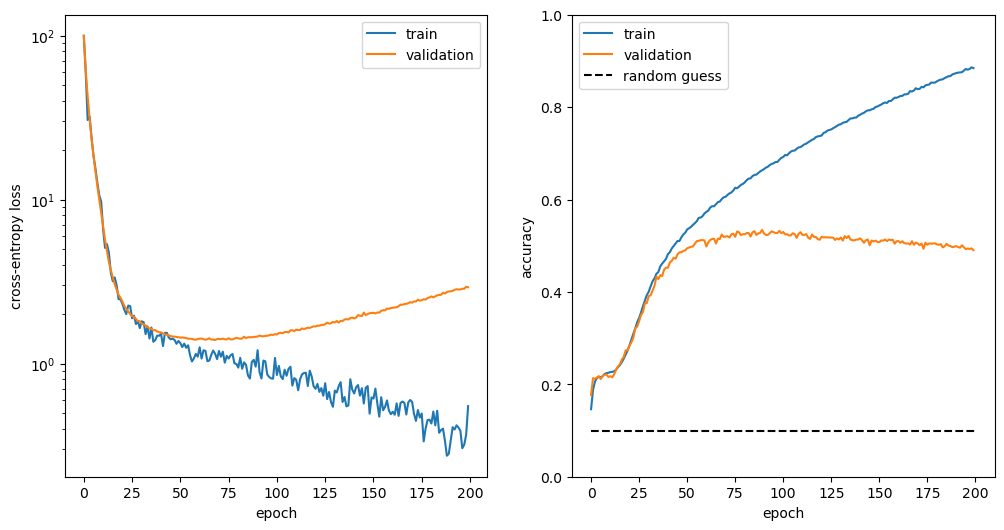

In [4]:
fig, axs = plt.subplots(1,2,figsize=(12,6))
# loss
axs[0].plot(metrics["loss_train"],label="train")
axs[0].plot(metrics["loss_valid"],label="validation")
axs[0].set_yscale("log")
axs[0].set_xlabel("epoch")
axs[0].set_ylabel("cross-entropy loss")
axs[0].legend(loc="upper right")
axs[1].set_ylim(0,1)
axs[1].plot(metrics["acc_train"],label="train")
axs[1].plot(metrics["acc_valid"],label="validation")
axs[1].plot([0,len(metrics["acc_train"])],[0.1,0.1],color="black",linestyle="--",label="random guess")
axs[1].set_xlabel("epoch")
axs[1].set_ylabel("accuracy")
axs[1].legend(loc="upper left")